# Evaluation of uncertainty of models on 60km -> 2.2km-4x over Birmingham

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
import math
import string

import IPython
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from properscoring import crps_ensemble
import xarray as xr

from mlde_analysis.data import prep_eval_data
from mlde_analysis.display import pretty_table
from mlde_analysis.uncertainty import plot_spread_error, plot_domain_means

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from mlde_analysis.default_params import *

In [ ]:
# Parameters
desc = "Comparison of diffusion model for CPMGEM-pr paper\nTest split\n12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set\nCompare techniques: diffusion, u-net, bilinear\n"
eval_vars = ["pr"]
derived_variables_config = {}
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
}
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 11,
        },
        {
            "label": "U-Net_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/deterministic/ukcp_local_pr_12em_plain_unet/bham_pSTV-ema-gradcl-256-batch",
                    "checkpoint": "epoch_100",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:orange",
            "order": 1,
        },
        {
            "label": "cCPM Bilinear",
            "sample_specs": [
                {
                    "fq_model_id": "id-linpr",
                    "checkpoint": "epoch_0",
                    "input_xfm": "none",
                    "dataset": "bham64_ccpm-4x_12em_linpr_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:grey",
            "order": 0,
            "UQ": False,
            "CCS": False,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                    "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "UQ": False,
            "color": "tab:green",
            "order": 20,
        }
    ],
}
sample_configs_at_60km = [
    {
        "label": "CPMGEM-GCM@60km",
        "sample_specs": [
            {
                "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV/postprocess/gcm-grid",
                "checkpoint": "epoch_20",
                "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                "variables": ["pr"],
            }
        ],
        "deterministic": False,
    }
]
dataset_configs_at_60km = {
    "CPM": "bham64_ccpm-60km_12em_pr_pr",
    "GCM": "bham64_gcm-60km_12em_rawpr_pr",
}
example_percentiles = {
    "CPM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
    "GCM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
}
example_overrides = {"CPM": {"JJA Wet": ["01", "1993-08-01 12:00:00"]}, "GCM": {}}
examples_sample_idxs = [2, 5]
niterations = 30


In [ ]:
IPython.display.Markdown(desc)

Comparison of diffusion model for CPMGEM-pr paper
Test split
12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set
Compare techniques: diffusion, u-net, bilinear


In [ ]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 12, time: 3240,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 3, sample_id: 6, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01' '04' ... '13' '15'
   * time                        (time) object 1981-03-01 12:00:00 ... 2076-08...
     season                      (time) int64 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
   * model                       (model) object 'CPMGEM_cCPM' ... 'cCPM Bilinear'
     time_period                 (time) <U8 'historic' 'historic' ... 'future'
     dec_adjusted_year           (time) int64 1981 1981 1981 ... 2076 2076 2076
     stratum                     (time) <U12 'historic MAM' ... 'future JJA'
     tp_season_year             

In [ ]:
CPM_DAS = { var: EVAL_DS["CPM"][f"target_{var}"] for var in eval_vars }

## Figure: skill & spread

* Domain mean precip scatter: samples ensemble mean vs CPM
* Spread-error
  * https://journals.ametsoc.org/view/journals/hydr/15/4/jhm-d-14-0008_1.xml?tab_body=fulltext-display
  * https://journals.ametsoc.org/view/journals/aies/2/2/AIES-D-22-0061.1.xml
  * https://www.sciencedirect.com/science/article/pii/S0021999107000812

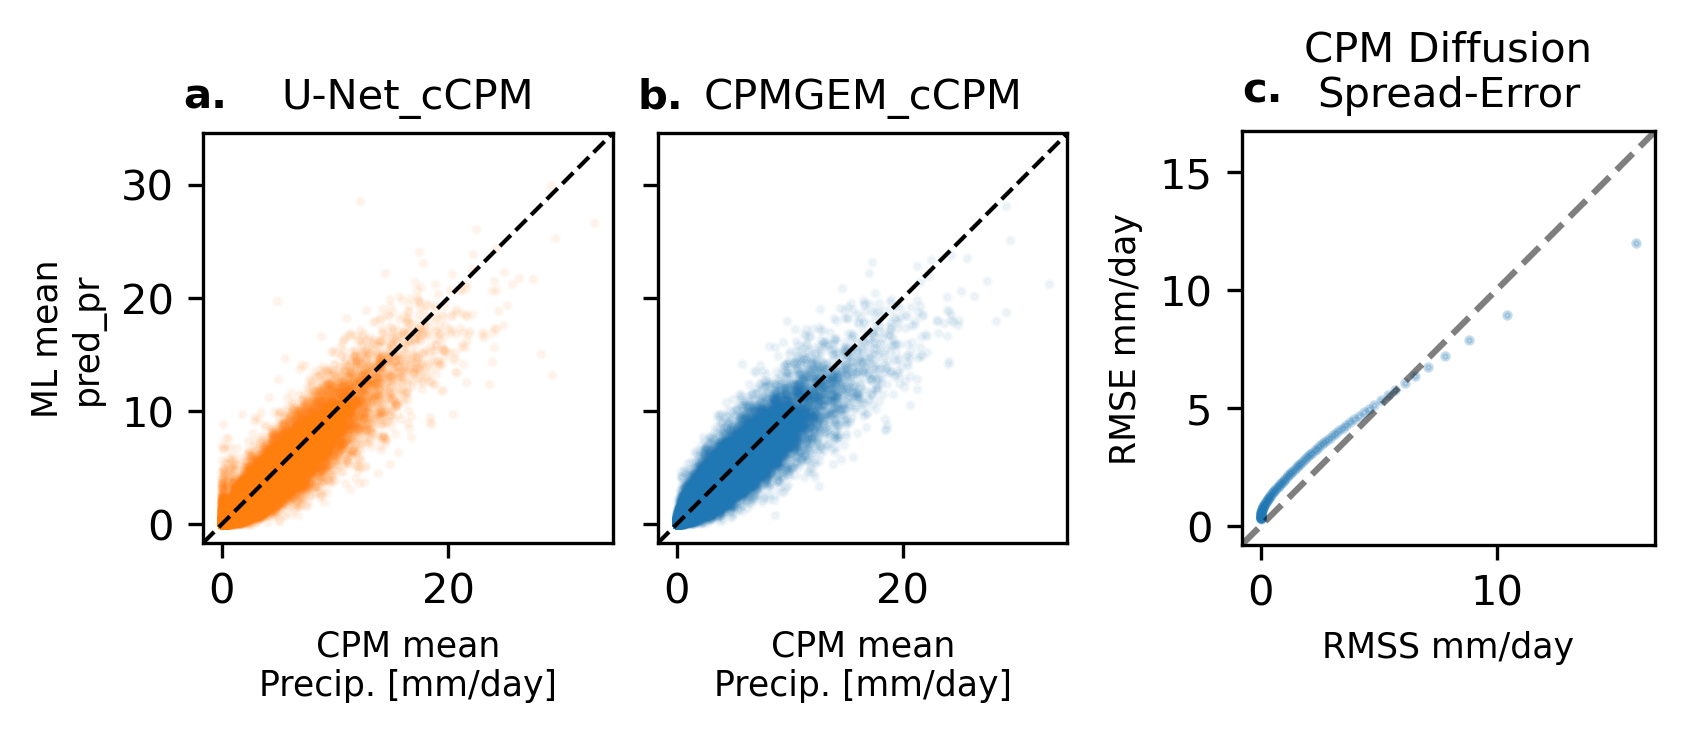

,pr domain mean corr
model,
U-Net_cCPM,0.94
CPMGEM_cCPM,0.94


In [ ]:
corr_coeff_das = []
for var in eval_vars:
    fig = plt.figure(layout='constrained', figsize=(5.5, 5.5*(2/3.0)))
    scatter_fig, ss_fig = fig.subfigures(1, 2, width_ratios=[2,1.075])

    mois = { model: mconfig for mconfigs in MODELS.values() for model, mconfig in mconfigs.items() if mconfig.get("UQ", True) }
    pred_das = [ EVAL_DS[mconfig["source"]][f"pred_{var}"].sel(model=model) for model, mconfig in mois.items() ]
        
    # pred_mean_da = pred_da.mean(dim=["grid_latitude", "grid_longitude", "sample_id"]).assign_attrs(pred_da.attrs)
    # target_mean_da = CPM_DAS[var].mean(dim=["grid_latitude", "grid_longitude"]).assign_attrs(CPM_DAS[var].attrs)

    mean_pred_da = xr.concat(pred_das, dim="model").mean(dim=["grid_latitude", "grid_longitude", "sample_id"])
    target_mean_da = CPM_DAS[var].mean(dim=["grid_latitude", "grid_longitude"])
    corr_coeff_das.append(xr.corr(mean_pred_da, target_mean_da, dim=["ensemble_member", "time"]).rename(f"{var} domain mean corr"))
    axd = scatter_fig.subplot_mosaic([mois.keys()], sharey=True, sharex=True)
    
    for idx, pred_da in enumerate(pred_das):
        model = pred_da.model.values.item()
        ax=axd[model]
        plot_domain_means(
            pred_da=pred_da.mean(dim="sample_id"), 
            target_da=CPM_DAS[var],
            ax=ax,
            line_props=mois[model],
        )
        ax.xaxis.set_tick_params(labelbottom=True)
        if idx > 0:
            ax.yaxis.label.set_visible(False)
        ax.annotate(
            f"{string.ascii_lowercase[idx]}.",
            xy=(-0.05, 1.04),
            xycoords=("axes fraction", "axes fraction"),
            weight="bold",
            ha="left",
            va="bottom",
        )
        
    mois = { model: mconfig for mconfigs in MODELS.values() for model, mconfig in mconfigs.items() if mconfig.get("UQ", True) and not mconfig["deterministic"] }
    pred_da = xr.concat([ EVAL_DS[mconfig["source"]][f"pred_{var}"].sel(model=model) for model, mconfig in mois.items() ], dim=pd.Index(mois.keys(), name="model"))
    
    axd = ss_fig.subplot_mosaic([["Spread-Error"]])
    ax = axd["Spread-Error"]
    plot_spread_error(pred_da=pred_da, target_da=CPM_DAS[var], ax=ax, line_props=mois)
    ax.annotate("c.", xy=(0, 1.05), xycoords=("axes fraction", "axes fraction"), weight='bold', ha="left", va="bottom")

    plt.show()
    
IPython.display.display_html(xr.merge(corr_coeff_das).to_dataframe().round(2).to_html(), raw=True)

### Figure: samples spread
* scatter of samples domain mean vs CPM

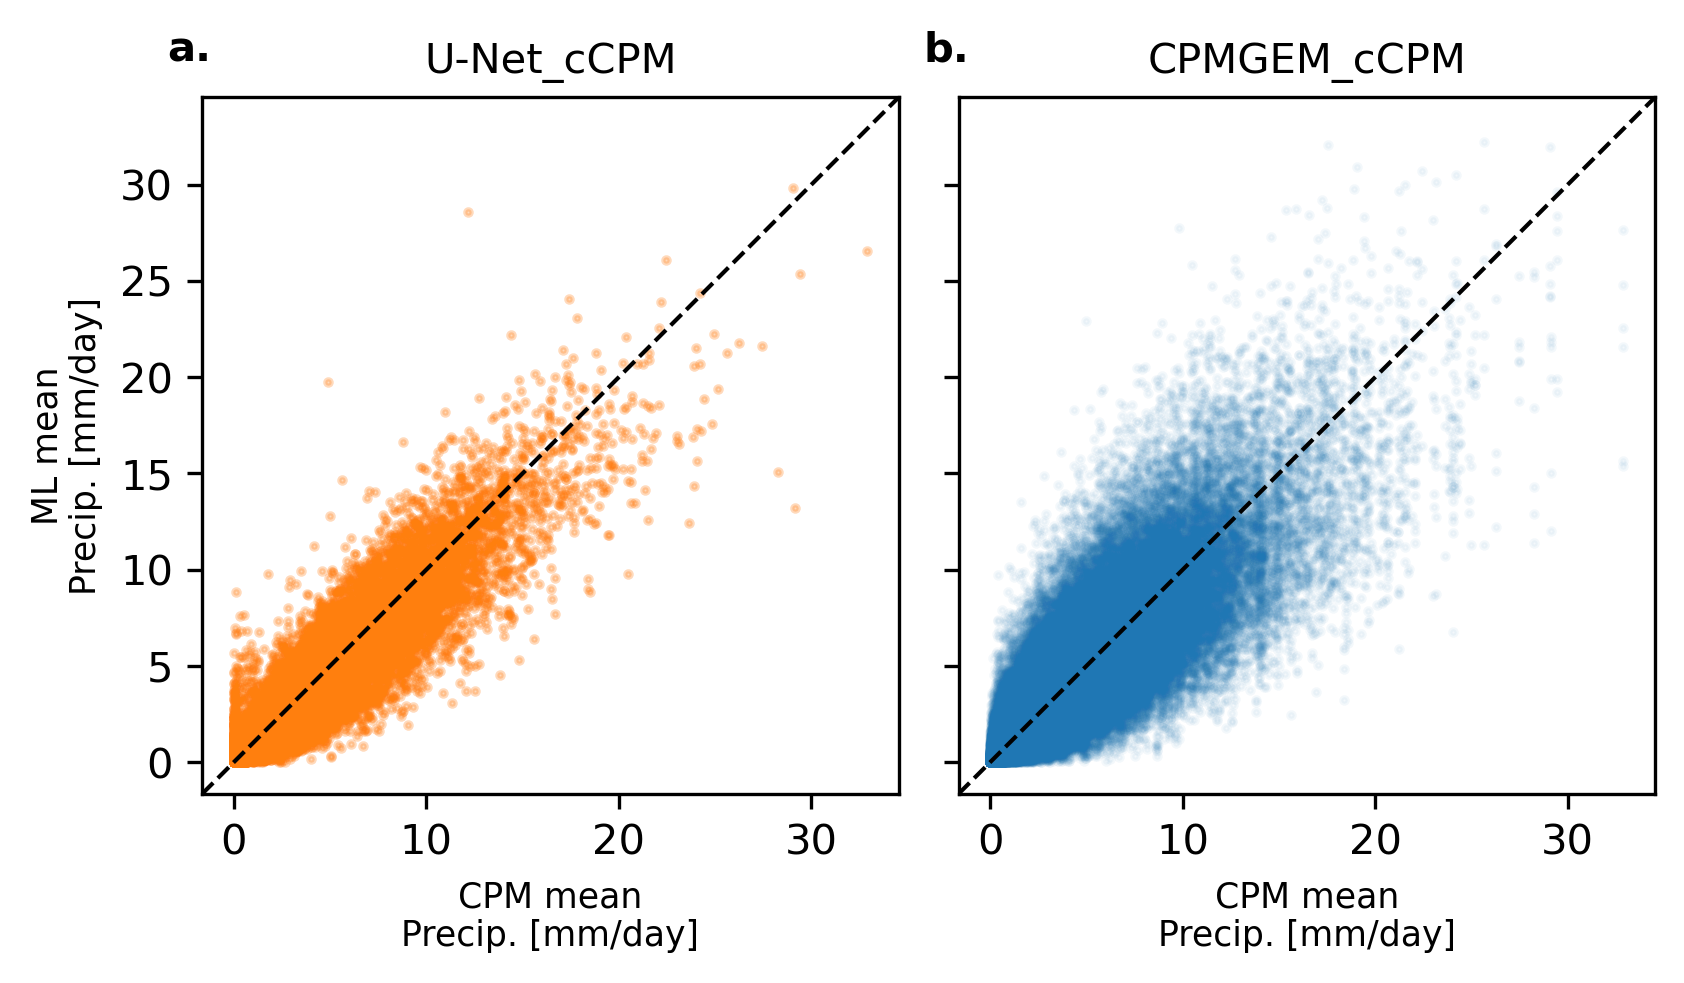

,pr domain mean corr
model,
U-Net_cCPM,0.94
CPMGEM_cCPM,0.88


In [ ]:
corr_coeff_das = []
for var in eval_vars:
    scatter_fig = plt.figure(layout='constrained', figsize=(5.5, 5.5*(2/3.0)))

    mois = { model: mconfig for mconfigs in MODELS.values() for model, mconfig in mconfigs.items() if mconfig.get("UQ", True) }
    pred_das = [ EVAL_DS[mconfig["source"]][f"pred_{var}"].sel(model=model) for model, mconfig in mois.items() ]
        
    # pred_mean_da = pred_da.mean(dim=["grid_latitude", "grid_longitude", "sample_id"]).assign_attrs(pred_da.attrs)
    # target_mean_da = CPM_DAS[var].mean(dim=["grid_latitude", "grid_longitude"]).assign_attrs(CPM_DAS[var].attrs)

    mean_pred_da = xr.concat(pred_das, dim="model").mean(dim=["grid_latitude", "grid_longitude"])
    target_mean_da = CPM_DAS[var].mean(dim=["grid_latitude", "grid_longitude"]).broadcast_like(mean_pred_da)
    corr_coeff_das.append(xr.corr(mean_pred_da, target_mean_da, dim=["ensemble_member", "time", "sample_id"]).rename(f"{var} domain mean corr"))
    axd = scatter_fig.subplot_mosaic([mois.keys()], sharey=True, sharex=True)
    
    for idx, pred_da in enumerate(pred_das):
        model = pred_da.model.values.item()
        ax=axd[model]
        plot_domain_means(
            pred_da=pred_da,
            target_da=CPM_DAS[var],
            ax=ax,
            line_props=mois[model],
        )
        ax.xaxis.set_tick_params(labelbottom=True)
        if idx > 0:
            ax.yaxis.label.set_visible(False)
        ax.annotate(
            f"{string.ascii_lowercase[idx]}.",
            xy=(-0.05, 1.04),
            xycoords=("axes fraction", "axes fraction"),
            weight="bold",
            ha="left",
            va="bottom",
        )
        
    mois = { model: mconfig for mconfigs in MODELS.values() for model, mconfig in mconfigs.items() if mconfig.get("UQ", True) and not mconfig["deterministic"] }
    pred_da = xr.concat([ EVAL_DS[mconfig["source"]][f"pred_{var}"].sel(model=model) for model, mconfig in mois.items() ], dim=pd.Index(mois.keys(), name="model"))

    plt.show()
    
IPython.display.display_html(xr.merge(corr_coeff_das).to_dataframe().round(2).to_html(), raw=True)

## CRPS

In [ ]:
def group_crps(model_forecast_da, truth_da):
    return xr.apply_ufunc(
        crps_ensemble,
        truth_da,
        model_forecast_da.squeeze("model"),
        input_core_dims=[truth_da.dims, model_forecast_da.squeeze("model").dims],  # list with one entry per arg
        output_core_dims=[["examples", "grid_latitude", "grid_longitude"]],
        # vectorize=True,
    ).rename("CRPS").mean()

for var in eval_vars:
    print(var)
    
    mois = { model: mconfig for mconfigs in MODELS.values() for model, mconfig in mconfigs.items() if mconfig.get("UQ", True) and not mconfig["deterministic"] }
    forecasts_da = xr.concat([ EVAL_DS[mconfig["source"]][f"pred_{var}"].sel(model=model) for model, mconfig in mois.items() ], dim=pd.Index(mois.keys(), name="model")).stack(example=["ensemble_member", "time"]).transpose("model", "example", "grid_latitude", "grid_longitude", "sample_id") 
    
    crps_scores = {}

    truth = CPM_DAS[var].stack(example=["ensemble_member", "time"]).transpose("example", "grid_latitude", "grid_longitude")
    
    crps_scores = forecasts_da.groupby("model", squeeze=False).map(group_crps, truth_da=truth)
    pretty_table(crps_scores, round=4)

pr


,CRPS
model,
CPMGEM_cCPM,1.0923
